# imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import numpy as np

print("TensorFlow version is: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version is: {}".format(tf.keras.__version__))

# labels and draw rect

In [2]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [3]:
labels = read_labels('coco.txt')
labels[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

In [4]:
import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] ), int(x[1] ), int(x[2] )), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

In [5]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def draw_bbs(filename, yhat):
    boxes = yhat[..., :4]
    pred_conf = yhat[..., 4:]
    boxes, scores, classes, valid_detections =  tf.image.combined_non_max_suppression(
        boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
        scores=tf.reshape(
                pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
        max_output_size_per_class=50,
        max_total_size=50,
        iou_threshold=.45,
        score_threshold=.5
    )
    pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]
    out_boxes, out_scores, out_classes, num_boxes = pred_bbox
    print(f'num_boxes[0].shape = {num_boxes[0]} out_boxes.shape = {out_boxes.shape}')
    print('------iteration started------')
    for i in range(num_boxes[0]):
        if int(out_classes[0][i]) < 0 or int(out_classes[0][i]) > len(labels): continue
        class_ind = int(out_classes[0][i])
        coor = out_boxes[0][i]
        class_name = labels[class_ind]
        print(f'coor_{i} - {class_name} === {coor}')
        coor[0] = int(coor[0] * image_h)
        coor[2] = int(coor[2] * image_h)
        coor[1] = int(coor[1] * image_w)
        coor[3] = int(coor[3] * image_w)
        fontScale = 0.5
        score = out_scores[0][i]
        
#         print(out_boxes.shape)  
    print('------iteration completed------')
    print(out_boxes.shape)  
    print('start drawing boxes')
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    
    colors = generate_colors(labels)
    out_classes = out_classes[0]
    out_scores = out_scores[0]
    out_boxes = out_boxes[0]
    print(f'out boxes shape is  {out_boxes.shape}')
    
    for i in range(num_boxes[0]):
        box = out_boxes[i]
        # get coordinates
#         print(f'box shape is {box}')
        y1, x1, y2, x2 = box[0], box[1], box[2], box[3]
        print(f'++++++++ object = {labels[int(out_classes[i])]} -   y1, x1, y2, x2 = {box[0]}, {box[1]}, {box[2]}, {box[3]}')
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        print(f'object = {labels[int(out_classes[i])]}({out_scores[i]*100})  w= {width}  h= {height}')
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color=colors[i])
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (labels[int(out_classes[i])], out_scores[i]*100)
        pyplot.text(x1, y1, label, color='yellow')
#     # show the plot
    pyplot.show()

In [6]:
import copy
from PIL import ImageDraw, ImageColor

def draw_bbs_coreml(filename, yhat):
    boxes = yhat[..., :4]
    pred_conf = yhat[..., 4:]
    boxes, scores, classes, valid_detections =  tf.image.combined_non_max_suppression(
        boxes= tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
        scores=tf.reshape(
                pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
        max_output_size_per_class=50,
        max_total_size=50,
        iou_threshold=.45,
        score_threshold=.5
    )
    pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]
    out_boxes, out_scores, out_classes, num_boxes = pred_bbox
    print(f'num_boxes[0].shape = {num_boxes[0]} out_boxes.shape = {out_boxes.shape}')
    print('------iteration staretd------')
    for i in range(num_boxes[0]):
        if int(out_classes[0][i]) < 0 or int(out_classes[0][i]) > len(labels): continue
        class_ind = int(out_classes[0][i])
        coor = out_boxes[0][i]
        class_name = labels[class_ind]
        new_coor = np.copy(coor)
        new_coor[0] = coor[1]
        new_coor[1] = coor[0]
        new_coor[2] = coor[3]
        new_coor[3] = coor[2]
#         coor = new_coor
        print(f'coor_{i} - {class_name} === {coor}')
        coor[0] = int(new_coor[0] * image_h)
        coor[2] = int(new_coor[2] * image_h)
        coor[1] = int(new_coor[1] * image_w)
        coor[3] = int(new_coor[3] * image_w)
        fontScale = 0.5
        score = out_scores[0][i]
        
#         print(out_boxes.shape)  
    print('------iteration completed------')
    print(out_boxes.shape)  
    print('start drawing boxes')
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    
    colors = generate_colors(labels)
    out_classes = out_classes[0]
    out_scores = out_scores[0]
    out_boxes = out_boxes[0]
    print(f'out boxes shape is  {out_boxes.shape}')
    
    for i in range(num_boxes[0]):
        box = out_boxes[i]
        # get coordinates
#         print(f'box shape is {box}')
        y1, x1, y2, x2 = box[0], box[1], box[2], box[3]
        print(f'++++++++ object = {labels[int(out_classes[i])]} -   y1, x1, y2, x2 = {box[0]}, {box[1]}, {box[2]}, {box[3]}')
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        print(f'object = {labels[int(out_classes[i])]}({out_scores[i]*100})  w= {width}  h= {height}')
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color=colors[i])
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (labels[int(out_classes[i])], out_scores[i]*100)
        pyplot.text(x1, y1, label, color='yellow')
#     # show the plot
    pyplot.show()

# load models 

In [ ]:
# yolo_model = load_model('yolov3Keras29thMay2022.h5')
yolo_model = load_model('yolov4-608')


In [15]:
# yolo_tiny_model = load_model('yolov4-tiny-608-1stJun')
yolo_tiny_model = load_model('yolo_tiny_1stJune.h5')


# load image

In [16]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [17]:
# Pre-process the image
input_w, input_h = 608, 608
photo_filename = '/Users/ankit/Desktop/test_image_samples/11631210275_bce9e1af20.jpeg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)

image initial size:  500 334
input image (1, 608, 608, 3)


# prediction

In [ ]:
# Run the model
yhat = yolo_model.predict(image)
print(f'y hat shape = {yhat.shape}')
print("output:",[a.shape for a in yhat])
draw_bbs(photo_filename, yhat)
# [0.2395002 0.7745519 0.3014686 0.9534064]
# coor_1 - kite === [0.65966535 0.08828039 0.7445483  0.1675079 ]

# coor_0 - person === [0.2395002 0.7745519 0.3014686 0.9534064]

ytinyhat shape : (1, 28, 84)
output: [(28, 84)]
num_boxes[0].shape = 11 out_boxes.shape = (1, 50, 4)
------iteration started------
coor_0 - sheep === [0.50771534 0.88858813 0.732394   0.9730508 ]
coor_1 - person === [0.11612079 0.02632987 0.7654853  0.21786073]
coor_2 - person === [0.13854273 0.6696421  0.65368026 0.800131  ]
coor_3 - person === [0.2647018  0.47616658 0.7060806  0.6070705 ]
coor_4 - person === [0.20236397 0.56591207 0.48806277 0.6480148 ]
coor_5 - bicycle === [0.4661291  0.47089827 0.7594044  0.6163101 ]
coor_6 - person === [0.29869756 0.8081308  0.52194756 0.8869651 ]
coor_7 - bicycle === [0.5319793  0.06009397 0.8605364  0.18256819]
coor_8 - bicycle === [0.36154836 0.69360626 0.7404751  0.80621225]
coor_9 - person === [0.16681167 0.40236965 0.5178407  0.53845495]
coor_10 - person === [0.3183667  0.7875797  0.43952158 0.8246432 ]
------iteration completed------
(1, 50, 4)
start drawing boxes
out boxes shape is  (50, 4)
++++++++ object = sheep -   y1, x1, y2, x2 = 169.

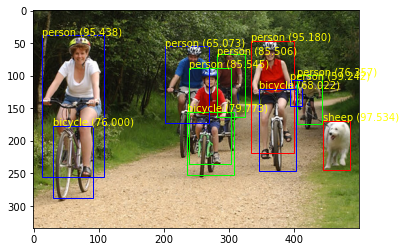

In [18]:
# Run the model
ytinyhat = yolo_tiny_model.predict(image)
print(f"ytinyhat shape : {ytinyhat.shape}")
print("output:",[a.shape for a in ytinyhat])
draw_bbs(photo_filename, ytinyhat)

# convert to coreml

In [27]:
yolo_tiny_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 609, 609, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 304, 304, 32) 864         zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 304, 304, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [28]:
import coremltools as ct

# coreml_model = ct.converters.keras.convert(yolo_tiny_model) 

coreml_model = ct.convert(
    yolo_tiny_model, output_names = ['my_output']
)

2022-06-01 18:40:01.052066: I tensorflow/core/grappler/devices.cc:60] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA support)
2022-06-01 18:40:01.052159: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-06-01 18:40:01.063846: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:797] Optimization results for grappler item: graph_to_optimize
2022-06-01 18:40:01.063862: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:799]   function_optimizer: function_optimizer did nothing. time = 0.002ms.
2022-06-01 18:40:01.063866: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:799]   function_optimizer: function_optimizer did nothing. time = 0ms.
2022-06-01 18:40:02.105988: I tensorflow/core/grappler/devices.cc:60] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA support)
2022-06-01 18:40:02.106096: I tensorflo

In [31]:
spec = coreml_model.get_spec()
type(coreml_model)

coremltools.models.model.MLModel

In [23]:
print(coreml_model)

input {
  name: "input_1"
  type {
    imageType {
      width: 608
      height: 608
      colorSpace: RGB
      imageSizeRange {
        widthRange {
          lowerBound: 608
          upperBound: 608
        }
        heightRange {
          lowerBound: 608
          upperBound: 608
        }
      }
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.2.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b3"
  }
}



In [32]:
output_path = 'tiny_yolov3Coreml_1stJune2022'
coreml_model.save(output_path)
print('Saved CoreML model to {}'.format(output_path))

Saved CoreML model to tiny_yolov3Coreml_1stJune2022


In [ ]:
from PIL import Image
def load_local_and_scale_image(image_path):
    image = Image.open(image_path)
    w,h = image.size
    min_dim = min(w,h)
    x0 = 0 #int((w - min_dim)/2)
    y0 = 0 #int((h - min_dim)/2)
    box = (x0, y0, x0 + min_dim, y0 + min_dim)
#     return image.crop(box=box).resize((608,608))
    return image.resize((608,608))

In [ ]:
image = load_local_and_scale_image(photo_filename)
image

In [ ]:
INPUT_NODE = 'input_1'
OUTPUT_NODE = 'Identity'
print(f'{INPUT_NODE} -- {OUTPUT_NODE}')

In [ ]:
preds = coreml_model.predict(data={INPUT_NODE: image})[OUTPUT_NODE]

In [ ]:
print(preds.shape)

In [ ]:
draw_bbs_coreml(photo_filename, preds)

In [ ]:
# tiny 
coreml_tiny_model = ct.convert(yolo_tiny_model, inputs=[ct.ImageType(scale=1 / 255.0)])

In [ ]:
print(coreml_tiny_model)

In [ ]:
output_path = 'yolov3Coreml_tiny_29thMay2022'
coreml_tiny_model.save(output_path)
print('Saved CoreML model to {}'.format(output_path))

In [ ]:
preds_tiny = coreml_tiny_model.predict(data={INPUT_NODE: image})[OUTPUT_NODE]
print(preds_tiny.shape)

In [ ]:
draw_bbs_coreml(photo_filename, preds_tiny)

In [ ]:
# quantized model
coreml_tiny_model_quantized = ct.models.neural_network.quantization_utils.quantize_weights(
    coreml_tiny_model, 
    nbits=16, 
    quantization_mode='linear')

In [ ]:
output_path = 'yolov3Coreml_tiny_quantized_29thMay2022'
coreml_tiny_model_quantized.save(output_path)
print('Saved CoreML model to {}'.format(output_path))

In [ ]:
preds_tiny_quantized = coreml_tiny_model_quantized.predict(data={INPUT_NODE: image})[OUTPUT_NODE]
print(preds_tiny.shape)

In [ ]:
draw_bbs_coreml(photo_filename, preds_tiny_quantized)

# crash course of numpy 

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def softmax_2d(x, axis=1):
    x_max = np.max(x, axis=axis)[:, np.newaxis]
    e_x = np.exp(x - x_max)
    x_sum = np.sum(e_x, axis=axis)[:, np.newaxis]    
    return e_x / x_sum

In [ ]:
x = np.array([[100, 20, 11],[9, 24, 10],[3, 4, 13],[5, 6, 15],[7, 8, -14]])
x

In [ ]:
x.shape


In [ ]:
softmax_x = softmax(x)
softmax_x

In [ ]:
np.max(x)

In [ ]:
diff_x = x - np.max(x)
diff_x

In [ ]:
diff_x.sum()

In [ ]:
diff_x /2

In [ ]:
softmax_2d_x = softmax_2d(x)
softmax_2d_x

In [ ]:
x_max = np.max(x, axis=1)
x_max



In [ ]:
x_max_exp_dim_1 = tf.reshape(x_max, shape=(-1, 1)) 
x_max_exp_dim_1

In [ ]:
x_max_exp_dim_2 = x_max.reshape(-1,1)
print(x_max_exp_dim_2)
print(x_max_exp_dim_2.shape)

In [ ]:
x_max_exp_dim_3 = x_max[:, np.newaxis]
print(x_max_exp_dim_1)
print(x_max_exp_dim_1.shape)


In [ ]:
print(x)
print('------------------')
print(x - x_max_exp_dim_1)



In [ ]:
x_sum = np.sum(e_x, axis=1)
x_sum

In [ ]:
np.sum([5.60279644e-09, 1.00000000e+00, 1.23409804e-04])


In [ ]:
test_arr = np.array([1,2,3,4,5,6]).reshape(1,-1)
print(test_arr)
print(test_arr.shape)
# test_arr = tf.reshape(test_arr, shape=(1, 6))
# print(test_arr.shape)
# print(test_arr)
print('-----------------')
test_arr = tf.reshape(test_arr, shape=(3, 2))
print(test_arr.shape)
print(test_arr)




In [ ]:
test_arr[..., :1]

In [ ]:
test_arr2 = [[3,7, 1], [5, -22, 100], [7, -2, 100]]
test_arr2 = sorted(test_arr2, key= lambda p : p[0], reverse=True)
print(test_arr2)

In [ ]:
test_arr3 = np.array([[3,7, 1], [5, -22, 100], [7, -2, 100]])
print(test_arr3)

In [ ]:
np.transpose(test_arr3, (1, 0))